# Research question: What is the relationship between the SHAP and feature value?
[not including the hospital feature]

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous notebook (03_xgb_combined_shap_key_features.ipynb) we looked at SHAP values for all the features (fitting models to k-fold data and comparing the differences of the SHAP values obtained across the 5 models). 

In our previous notebook (03a_xgb_combined_shap_key_features.ipynb) we fited a single model to all of the data (no test set) and focused on understanding the SHAP values for each of the one-hot encoded hosptial features that make up the *Stroke team* categorical feature.

In this notebook we will use the model from notebook 03a (all data model) and focus on understanding the relationship between the SHAP and feature values for the other 9 features.

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we read in an already fitted XGBoost model to the SAMueL dataset (and the SHAP values), to predict whether a patient recieves thrombolysis from the values of 10 features, using all data to train (no test set). We explore the relationship between SHAP values adn feature values for 9 features (not the hospital feature).

## Model and data

XGBoost model was trained on all of the data (no test set used). The 10 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Did the patient receive thrombolysis (0 = No, 1 = Yes)

## Aims

* Fit XGBoost model using feature data (no test set) to predict whether patient gets thrombolysis
* Calculate the SHAP values of the features
* Understand the relationship between the SHAP value and feature values for all features (apart from the hospital feature)

## Observations
* Stroke type: The SHAP values for stroke type show that the model effectively eliminated any probability of receiving thrombolysis for non-ischaemic (haemorrhagic) stroke.
*  Arrival-to-scan time: The odds of receiving thrombolysis reduced by about 20 fold over the first 100 minutes of arrival to scan time.
* Stroke severity (NIHSS): The odds of receiving thrombolysis were lowest at NIHSS 0, increased and peaked at NIHSS 15-25, and then fell again with higher stroke severity (NIHSS above 25). The difference between minimum odds (at NIHSS 0) and maximum odds (at 15-25) of receiving thrombolysis was 30-35 fold.
* Stroke onset time type (precise vs. estimated): The odds of receiving thrombolysis were about 3 fold greater for precise onset time than estimated onset time.
* Disability level (mRS) before stroke: The odds of receiving thrombolysis fell about 5 fold between mRS 0 and 5.

### Extra code to check something for the paper

In notebook 03_xgb_combined_shap_key_features.ipynb we used the training set from the first kfold to plot the feature value vs SHAP for the top 6 influencial features.

Here we use the 'all data model', and look at all features to inform the subgroup analysis (to include all features for that too, rather than the selected 3 features)

## Show the relationship between feature value and SHAP value for all the features

## Import modules

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from sklearn import linear_model

import os
import pickle

import math # to .floor and .ceil

# So can take deep copy
import copy

from os.path import exists
import json

## Set filenames

In [2]:
# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '03d'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)   

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

For this exercise, we will fit a model using all of the data (rather than train/test splits used to assess accuracy). We will join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty list
test_data_kfold = []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=dict_feature_name, inplace=True)
    test_data_kfold.append(test)

# Join all the test sets. Set "ignore_index = True" to reset the index in the
#   new dataframe (to run from 0 to n-1), otherwise get duplicate index values
data = pd.concat(test_data_kfold, ignore_index=True)

## Get list of feature names

In [7]:
feature_names = list(test_data_kfold[0])

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [8]:
X = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [9]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


### One-hot encode hospital feature

In [10]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X_combined = X.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X['Stroke team'], prefix = 'team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('Stroke team', axis=1, inplace=True)

In [11]:
# get feature names
feature_names_ohe = list(X)

## Load XGBoost model

An XGBoost model was trained on the full dataset (rather than train/test splits used to assess accuracy) in notebook 03a_xgb_shap_values_focus_on_ohe_hospitals.ipynb

In [12]:
# Load models
filename = (f'./saved_models/03a_{model_text}.p')
with open(filename, 'rb') as filehandler:
    model = pickle.load(filehandler)
        
# Get the predictions for each patient 
#   (the classification, and the probability of being in either class)
y_pred = model.predict(X)
y_pred_proba = model.predict_proba(X)

# Calculate the models accuracy
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.878


## SHAP values

SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios.

### Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees.
Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

In [13]:
%%time
# Set up method to estimate SHAP values for tree models and ensembles of trees

filename = f'./output/03a_{model_text}_shap_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    print("Run notebook 03a")
    
# Get SHAP values
filename = f'./output/03a_{model_text}_shap_values_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load explainer
    with open(filename, 'rb') as filehandler:
        shap_values_extended = pickle.load(filehandler)
else:
    print("Run notebook 03a")

CPU times: user 521 ms, sys: 1.52 s, total: 2.04 s
Wall time: 264 ms


The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [14]:
shap_values_extended[0]

.values =
array([ 7.56502628e-01,  4.88319576e-01,  1.10273695e+00,  4.40223962e-01,
        4.98975307e-01,  2.02812225e-01, -2.62601525e-01,  3.69181409e-02,
        2.30234995e-01,  3.20923195e-04, -6.03703642e-03, -7.17267860e-04,
        0.00000000e+00, -4.91688668e-04,  1.20360847e-03,  1.77788886e-03,
       -4.34198463e-03, -2.76021136e-04, -2.79896380e-03,  3.52182891e-03,
       -2.73969141e-04,  8.53505917e-03, -5.28220041e-03, -8.25227005e-04,
        6.20208494e-03,  6.92215608e-03, -6.32244349e-03, -3.35367222e-04,
        7.81939551e-03, -4.71850217e-06, -4.25534381e-05,  6.48253039e-03,
        8.43156071e-04, -6.28353562e-04, -1.25156669e-02, -7.92063680e-03,
       -1.99409085e-03, -5.05548809e-03, -3.90118686e-03,  1.30317558e-03,
        0.00000000e+00, -6.48246554e-04,  1.19629130e-03,  8.26304778e-04,
        1.28053436e-02,  2.55714403e-03, -3.20375757e-03,  4.23251512e-03,
       -7.19791185e-03,  4.02670400e-03,  3.75146419e-03,  8.31848301e-04,
        3.45067

## Create order of features to include in the violin plots

Rank features by SHAP value

Taking the mean |SHAP| for each feature (across all patients), rank the features by SHAP value

#### Get average SHAP values for each feature (across all the patients)

Calculate the mean SHAP value for each feature (across all instances), in three ways:
* mean of raw values
* mean of absolute values
* absolute of mean of raw values

In [15]:
# Get SHAP values
shap_values = shap_values_extended.values

# Calculate mean SHAP value for each feature (across all instances)
df_shap_values_mean = pd.DataFrame(index=feature_names_ohe)
df_shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
df_shap_values_mean['abs_mean_shap'] = np.abs(df_shap_values_mean['mean_shap'])
df_shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
df_shap_values_mean['rank'] = df_shap_values_mean['mean_abs_shap'].rank(
    ascending=False).values
df_shap_values_mean.sort_values('rank', inplace=True, ascending=True)
df_shap_values_mean.head(10)

,mean_shap,abs_mean_shap,mean_abs_shap,rank
Infarction,-0.974695,0.974695,1.540489,1.0
Arrival-to-scan time,-0.385795,0.385795,0.991457,2.0
Stroke severity,-0.196834,0.196834,0.915676,3.0
Precise onset time,-0.061659,0.061659,0.538988,4.0
Prior disability level,-0.005883,0.005883,0.387559,5.0
Use of AF anticoagulants,-0.041382,0.041382,0.310106,6.0
Onset-to-arrival time,-0.066359,0.066359,0.291748,7.0
Age,-0.014048,0.014048,0.167593,8.0
Onset during sleep,-0.024299,0.024299,0.102481,9.0
team_VKKDD9172T,-0.005500,0.005500,0.029842,10.0


Take first 9 features (assuming that all of the teams one-hot encoded features are ranked below the other features.

In [16]:
features_shap_ranked = list(df_shap_values_mean.head(9).index)

### Show the relationship between feature value and SHAP value for all of the features
(as violin plots)

Resource: 
https://towardsdatascience.com/binning-records-on-a-continuous-variable-with-pandas-cut-and-qcut-5d7c8e11d7b0
https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html

In [17]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    rotation [integer] = xtick label rotation
    feat [string] = used in the axis label, the feature that is being plotted
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=10)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'SHAP values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)

Stroke type: The SHAP values for stroke type show that the 
model effectively eliminated any probability of receiving 
thrombolysis for non-ischaemic (haemorrhagic) stroke. The 
odds of receiving thrombolysis fell about 7359.87 
fold.

Arrival-to-scan time: The odds of receiving thrombolysis reduced by 
about 9.44 (20) fold over the first 120 minutes of arrival to scan time.

Stroke severity (NIHSS): The odds of receiving thrombolysis were lowest
 at NIHSS 0, increased and peaked at NIHSS 15-25, and then fell again 
with higher stroke severity (NIHSS above 25). The difference between 
minimum odds (at NIHSS 0) and maximum odds (at 15-25) of receiving 
thrombolysis was 29.5 (30-35) fold.

Stroke onset time type (precise vs. estimated): The odds of receiving 
thrombolysis were about 3.36 (3) fold greater for precise onset time than 
estimated onset time.

Disability level (mRS) before stroke: The odds of receiving 
thrombolysis fell about 6.7 (5) fold between mRS 0 and 5.

Use of AF anti

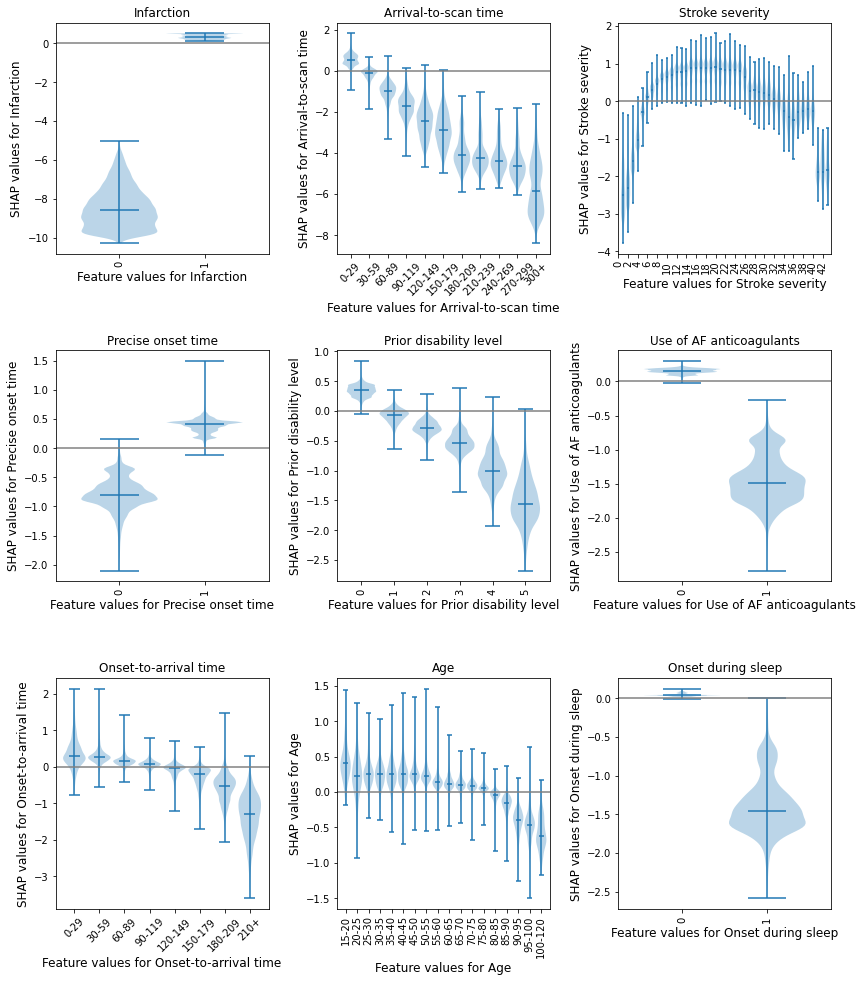

In [70]:
# Feature Age needs special consideration. It needs the x ticks to be created,
# as the other features with over 50 unique values, but age is already grouped 
# for the model (into 5yr groups) and so is treated as the other type.

fig = plt.figure(figsize=(12,14), constrained_layout=True)
# for each feature, prepare the data for the violin plot.
# data either already in categories, or if there's more than 50 unique values
# for a feature then assume it needs to be binned, and a violin for each bin
for n, feat in enumerate(features_shap_ranked):    
    feature_data = shap_values_extended[:, feat].data
    feature_shap = shap_values_extended[:, feat].values

    # if feature has more that 50 unique values, then assume it needs to be 
    # binned (other assume they are unique categories)
    if np.unique(feature_data).shape[0] > 50:
        # bin the data, create a violin per bin
        
        # settings for the plot
        rotation = 45
        step = 30
        n_bins = min(11, np.int((feature_data.max())/step))
        
        # create list of bin values
        bin_list = [(i*step) for i in range(n_bins)]
        bin_list.append(feature_data.max())

        # create list of bins (the unique categories)
        category_list = [f'{i*step}-{((i+1)*step-1)}' for i in range(n_bins-1)]
        category_list.append(f'{(n_bins-1)*step}+')

        # bin the feature data
        feature_data = pd.cut(feature_data, bin_list, labels=category_list, 
                              right=False)

    else:
        # create a violin per unique value
        
        # settings for the plot
        rotation = 90
        
        # create list of unique categories in the feature data
        # Age needs to keep its decimal value (midpoint between 5 yrs)
        category_list = np.unique(feature_data)
        if feat != 'Age':
            category_list = [int(i) for i in category_list]

    # create a list, each entry contains the corresponsing SHAP value for that 
    # category (or bin). A violin will represent each list.    
    shap_per_category = []
    for category in category_list:
        mask = feature_data == category
        shap_per_category.append(feature_shap[mask])

    if feat == "Infarction":
        range_shap_log_odds = np.median(shap_per_category[1]) - np.median(shap_per_category[0])
        odds = math.exp(range_shap_log_odds)
        print(f"Stroke type: The SHAP values for stroke type show that the \n"
              f"model effectively eliminated any probability of receiving \n"
              f"thrombolysis for non-ischaemic (haemorrhagic) stroke. The \n"
              f"odds of receiving thrombolysis fell about {round(odds,2)} \n"
              f"fold.\n")    
    if feat == "Arrival-to-scan time":
        range_shap_log_odds = np.median(shap_per_category[0]) - np.median(shap_per_category[3])
        odds = math.exp(range_shap_log_odds)
        print(f"Arrival-to-scan time: The odds of receiving thrombolysis reduced by \n"
        f"about {round(odds,2)} (20) fold over the first 120 minutes of arrival to scan time.\n")    
    if feat == "Stroke severity":
        range_shap_log_odds = np.median(shap_per_category[19]) - np.median(shap_per_category[0])
        odds = math.exp(range_shap_log_odds)
        print(f"Stroke severity (NIHSS): The odds of receiving thrombolysis were lowest\n"
          f" at NIHSS 0, increased and peaked at NIHSS 15-25, and then fell again \n"
          f"with higher stroke severity (NIHSS above 25). The difference between \n"
          f"minimum odds (at NIHSS 0) and maximum odds (at 15-25) of receiving \n"
          f"thrombolysis was {round(odds,2)} (30-35) fold.\n")
    if feat == "Precise onset time":
        range_shap_log_odds = np.median(shap_per_category[1]) - np.median(shap_per_category[0])
        odds = math.exp(range_shap_log_odds)
        print(f"Stroke onset time type (precise vs. estimated): The odds of receiving \n"
          f"thrombolysis were about {round(odds,2)} (3) fold greater for precise onset time than \n"
          f"estimated onset time.\n")
    if feat == "Prior disability level":
        range_shap_log_odds = np.median(shap_per_category[0]) - np.median(shap_per_category[5])
        odds = math.exp(range_shap_log_odds)
        print(f"Disability level (mRS) before stroke: The odds of receiving \n"
        f"thrombolysis fell about {round(odds,2)} (5) fold between mRS 0 and 5.\n")
    if feat == "Use of AF anticoagulants":
        range_shap_log_odds = np.median(shap_per_category[0]) - np.median(shap_per_category[1])
        odds = math.exp(range_shap_log_odds)
        print(f"Use of AF anticoagulants: The odds of receiving thrombolysis were about\n"
        f" {round(odds,2)} fold greater for no use.\n")
    if feat == "Onset-to-arrival time":
        range_shap_log_odds = np.median(shap_per_category[4]) - np.median(shap_per_category[7])
        odds = math.exp(range_shap_log_odds)
        print(f"Onset-to-arrival time: The odds of receiving thrombolysis were similar \n"
        f"below 120 minutes, then fell about {round(odds,2)} fold between 120 and above.\n")
    if feat == "Age":
        range_shap_log_odds = np.median(shap_per_category[13]) - np.median(shap_per_category[17])
        odds = math.exp(range_shap_log_odds)
        print(f"Age: The odds of receiving thrombolysis were similar below 80 years \n"
        f"old, then fell about {round(odds,2)} fold between 80 and 120 years old.\n")
    if feat == "Onset during sleep":
        range_shap_log_odds = np.median(shap_per_category[0]) - np.median(shap_per_category[1])
        odds = math.exp(range_shap_log_odds)
        print(f"Onset during sleep: The odds of receiving thrombolysis were about \n"
        f"{round(odds,2)} fold lower for onset during sleep.\n")

    if feat == 'Age':
        # create text of x ticks
        category_list = [f'{int(i-2.5)}-{int(i+2.5)}' for i in category_list]

        # SSNAP dataset had oldest age category as 100-120 (not a 5 yr band as 
        #   the other ages). Check if last age category is "110", then overwrite
        #   the label with the correct band (100-120, and not 107-112 as above 
        #   would create)
        if category_list[-1] == '107-112':
            category_list[-1] = '100-120'
    nrows = math.ceil(len(features_shap_ranked)/4)
    # create violin plot
    ax = fig.add_subplot(nrows,3,n+1)
    
    ax.violinplot(shap_per_category, showmedians=True, widths=0.9)
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([0, len(feature_values)], [0,0],c='0.5')   

    # customise the axes
    ax = set_ax(ax, category_list, feat, rotation=rotation)
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    
    # Adjust stroke severity tickmarks
    if feat == 'Stroke severity':
        ax.set_xticks(np.arange(0, len(category_list), 2))
        ax.set_xticklabels(category_list[0::2])   
    
    # Add title
    ax.set_title(feat)
    
plt.tight_layout(pad=2)
    
fig.savefig(f'output/{notebook}_{model_text}_thrombolysis_shap_violin_all_'
            f'features.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)

plt.show()

Calculate odds (from log odds) for the paper

### Compare SHAP values for the hospital one-hot encoded features

The hospital feature is one-hot encoded, so there is a SHAP value per stroke team. We will use this to create a histogram of the frequency of the SHAP value for the hospital feature (using only the first k-fold test set, and take the mean of the SHAP values for the instances for each hospital's own patients).

In [19]:
data['Stroke team']

0        TXHRP7672C
1        SQGXB9559U
2        LFPMM4706C
3        MHMYL4920B
4        EQZZZ5658G
            ...    
88787    OYASQ1316D
88788    SMVTP6284P
88789    RDVPJ0375X
88790    FAJKD7118X
88791    QWKRA8499D
Name: Stroke team, Length: 88792, dtype: object

In [21]:
# Set up list for storing patient data and hospital SHAP
feature_data_with_shap = []

# Get mean SHAP for stroke team when patient attending that stroke team
data_stroke_team = data['Stroke team']
stroke_teams = list(np.unique(data_stroke_team))
stroke_teams.sort()
stroke_team_mean_shap = []
# Loop through stroke teams
for stroke_team in stroke_teams:
    # Identify rows in test data that match each stroke team
    mask = data_stroke_team == stroke_team
    stroke_team_shap_all_features = shap_values[mask]
    # Get column index for stroke_team_in_shap
    feature_name = 'team_' + stroke_team
    index = feature_names_ohe.index(feature_name)
    # Get SHAP values for hospital
    stroke_team_shap = stroke_team_shap_all_features[:, index]
    # Get mean
    mean_shap = np.mean(stroke_team_shap)
    # Store mean
    stroke_team_mean_shap.append(mean_shap)
    # Get and store feature data and add SHAP
    feature_data = data[mask]
    feature_data['Hospital_SHAP'] = stroke_team_shap
    feature_data_with_shap.append(feature_data)

# Concatenate and save feature_data_with_shap
feature_data_with_shap = pd.concat(feature_data_with_shap, axis=0)
feature_data_with_shap.to_csv(
   f'./predictions/{notebook}_{model_text}_feature_data_with_hospital_shap.csv', 
    index=False)

# Create and save shap mean value per hospital
hospital_data = pd.DataFrame()
hospital_data["stroke_team"] = stroke_teams
hospital_data["shap_mean"] = stroke_team_mean_shap
hospital_data.to_csv(
    f'./predictions/{notebook}_{model_text}_mean_shap_per_hospital.csv', 
    index=False)

In [22]:
hospital_data

,stroke_team,shap_mean
0,AGNOF1041H,-0.026516
1,AKCGO9726K,0.520501
2,AOBTM3098N,-0.401549
3,APXEE8191H,0.000000
4,ATDID5461S,0.182610
...,...,...
127,YPKYH1768F,-0.166696
128,YQMZV4284N,0.388534
129,ZBVSO0975W,-0.573069
130,ZHCLE1578P,0.139613


Plot histogram of the frequency of the mean SHAP value for the instances for each hospital's own patients

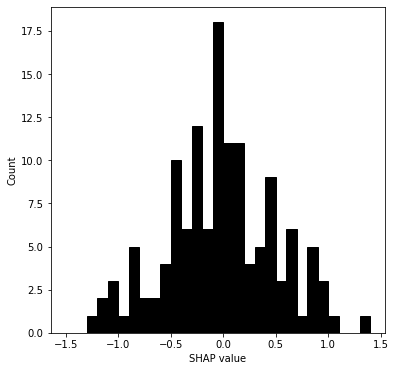

In [29]:
# Plot histogram
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(stroke_team_mean_shap, bins=np.arange(-1.5, 1.5, 0.1), 
        color='k', ec='k')
ax.set_xlabel('SHAP value')
ax.set_ylabel('Count')
plt.savefig(f'./output/{notebook}_{model_text}_hosp_shap_hist.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

### Plot histogram using same colour scheme as violin plot (for paper)
 
Code used to get colour of violin plots
Resource: https://stackoverflow.com/questions/26291479/changing-the-color-of-matplotlibs-violin-plots

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
vp = ax.violinplot(shap_per_category, showmedians=True, widths=0.9)

for vp1 in vp['bodies']:
    facecolor =  vp1.get_edgecolor()
    #facecolor = [0.12156863, 0.46666667, 0.70588235, 0.3]
    edgecolour = vp['cmedians'].get_colors()
    #edgecolour= [0.12156863, 0.46666667, 0.70588235, 1.]

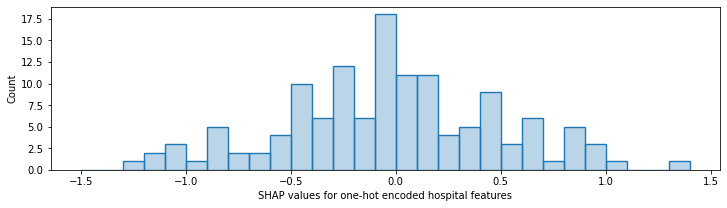

In [49]:
# Plot histogram
fig = plt.figure(figsize=(12,3))#figsize=(6,6))
ax = fig.add_subplot()
ax.hist(stroke_team_mean_shap, bins=np.arange(-1.5, 1.5, 0.1), 
        color=[0.12156863, 0.46666667, 0.70588235, 0.3], 
        ec=[0.12156863, 0.46666667, 0.70588235, 1.], linewidth=1.4)
ax.set_xlabel('SHAP values for one-hot encoded hospital features')
ax.set_ylabel('Count')
plt.savefig(f'./output/{notebook}_{model_text}_hosp_shap_hist.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

Log odds to odds

In [56]:
range_shap_log_odds = max(stroke_team_mean_shap) - min(stroke_team_mean_shap)
odds = math.exp(range_shap_log_odds)
print(f"There was a {round(odds,2)} fold difference in odds of receiving thrombolysis between hospitals")

There was a 13.6 fold difference in odds of receiving thrombolysis between hospitals


### How does the SHAP value for patient features compare to the thrombolysis rate of the hospital?

Create dataframe containing the hospital's IVT rate and median SHAP value for each feature (for those patients that attend the hospital).

In [71]:
# Calculate IVT rate per hosptial
hosp_ivt_rate = data.groupby(by=["Stroke team"]).mean()["Thrombolysis"]
hosp_ivt_rate

Stroke team
AGNOF1041H    0.352468
AKCGO9726K    0.369748
AOBTM3098N    0.218803
APXEE8191H    0.226481
ATDID5461S    0.240385
                ...   
YPKYH1768F    0.246057
YQMZV4284N    0.236170
ZBVSO0975W    0.250000
ZHCLE1578P    0.223639
ZRRCV7012C    0.157670
Name: Thrombolysis, Length: 132, dtype: float64

In [113]:
unique_stroketeams_list = list(set(data["Stroke team"]))
shap_values = shap_values_extended.values

# Create dataframe with hospital along index, column per feature, containing
# median SHAP value for feature for patients that attend that hospital
median_values_hosp = []
for h in unique_stroketeams_list:
#    calcualte median shap for the patients that attend hospital
    mask = data["Stroke team"] == h
    median_values_hosp.append(np.median(shap_values[mask],axis=0))

df_median_shap_values_per_hosp = pd.DataFrame(data=median_values_hosp, 
                                              index=unique_stroketeams_list,
                                              columns=feature_names_ohe)


In [114]:
df_median_shap_values_per_hosp.head(10)

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,team_AGNOF1041H,...,team_XKAWN3771U,team_XPABC1435F,team_XQAGA4299B,team_XWUBX0795L,team_YEXCH8391J,team_YPKYH1768F,team_YQMZV4284N,team_ZBVSO0975W,team_ZHCLE1578P,team_ZRRCV7012C
CNBGF2713O,0.648007,0.313526,-0.084391,0.266955,0.316369,0.183601,-0.016096,0.033696,0.023135,0.001011,...,-0.007639,0.001952,0.003269,-0.004961,0.000571,0.000010,-0.001658,0.002115,-0.001371,0.002244
UALFR2142B,-0.287873,0.240931,0.050026,0.262097,0.271370,0.146735,0.024119,0.035143,0.045624,0.000719,...,-0.009056,0.003447,0.003338,-0.002366,0.000255,0.000262,-0.001622,0.002358,-0.001633,0.002825
OKVRY7006H,0.267958,0.297781,0.196918,-0.311535,0.246114,0.148661,0.132020,0.039454,0.058468,0.000838,...,-0.009284,0.003451,0.002899,-0.003113,0.000384,0.000683,-0.001891,0.002446,-0.001678,0.002824
FLVXS2956M,0.414227,0.311638,0.347694,0.338794,0.029986,0.153958,0.062017,0.035031,0.032740,0.001038,...,-0.007581,0.003213,0.003185,-0.003654,0.000384,0.000262,-0.001764,0.002346,-0.001482,0.003422
DZJVD1372Z,0.339327,0.291655,0.259213,0.238247,0.211112,0.134613,0.036551,0.036981,0.022837,0.000845,...,-0.007722,0.003344,0.003285,-0.003926,0.000479,0.000262,-0.001835,0.002304,-0.001553,0.003118
GKONI0110I,0.100928,0.289846,0.156460,-0.356453,0.229964,0.141729,0.053487,0.041187,0.038142,0.000663,...,-0.009266,0.003495,0.003082,-0.002428,0.000294,0.000683,-0.001736,0.002366,-0.001679,0.003266
QOAPO4699N,0.425817,0.337145,0.280715,0.340686,0.289039,0.145254,0.041869,0.037705,0.063812,0.000835,...,-0.008109,0.003434,0.003154,-0.002923,0.000480,0.000683,-0.001915,0.002496,-0.001545,0.003059
JRXDG8181O,-0.138614,0.291907,0.360834,0.248010,0.281699,0.154962,0.087196,0.039986,0.099946,0.000740,...,-0.009471,0.003462,0.003154,-0.001977,0.000284,0.000262,-0.001863,0.002639,-0.001634,0.003325
DNOYM6465G,0.450841,0.346139,0.287619,0.384088,0.331446,0.153625,0.035572,0.037454,0.035774,0.000957,...,-0.007158,0.003397,0.003157,-0.003663,0.000639,0.000683,-0.001893,0.002583,-0.000938,0.002242
VKHPY9501A,0.404269,0.299724,-0.219765,0.315682,0.248192,0.146277,0.042273,0.036322,0.119543,0.000919,...,-0.007662,0.003451,0.003341,-0.003772,0.000480,0.000262,-0.001624,0.002277,-0.001576,0.002242


In [115]:
# Join IVT rate with admissions per hosptial
df_median_shap_values_per_hosp = df_median_shap_values_per_hosp.join(hosp_ivt_rate)

In [116]:
df_median_shap_values_per_hosp.head(10)

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,team_AGNOF1041H,...,team_XPABC1435F,team_XQAGA4299B,team_XWUBX0795L,team_YEXCH8391J,team_YPKYH1768F,team_YQMZV4284N,team_ZBVSO0975W,team_ZHCLE1578P,team_ZRRCV7012C,Thrombolysis
CNBGF2713O,0.648007,0.313526,-0.084391,0.266955,0.316369,0.183601,-0.016096,0.033696,0.023135,0.001011,...,0.001952,0.003269,-0.004961,0.000571,0.000010,-0.001658,0.002115,-0.001371,0.002244,0.480263
UALFR2142B,-0.287873,0.240931,0.050026,0.262097,0.271370,0.146735,0.024119,0.035143,0.045624,0.000719,...,0.003447,0.003338,-0.002366,0.000255,0.000262,-0.001622,0.002358,-0.001633,0.002825,0.267697
OKVRY7006H,0.267958,0.297781,0.196918,-0.311535,0.246114,0.148661,0.132020,0.039454,0.058468,0.000838,...,0.003451,0.002899,-0.003113,0.000384,0.000683,-0.001891,0.002446,-0.001678,0.002824,0.237500
FLVXS2956M,0.414227,0.311638,0.347694,0.338794,0.029986,0.153958,0.062017,0.035031,0.032740,0.001038,...,0.003213,0.003185,-0.003654,0.000384,0.000262,-0.001764,0.002346,-0.001482,0.003422,0.316294
DZJVD1372Z,0.339327,0.291655,0.259213,0.238247,0.211112,0.134613,0.036551,0.036981,0.022837,0.000845,...,0.003344,0.003285,-0.003926,0.000479,0.000262,-0.001835,0.002304,-0.001553,0.003118,0.241144
GKONI0110I,0.100928,0.289846,0.156460,-0.356453,0.229964,0.141729,0.053487,0.041187,0.038142,0.000663,...,0.003495,0.003082,-0.002428,0.000294,0.000683,-0.001736,0.002366,-0.001679,0.003266,0.389153
QOAPO4699N,0.425817,0.337145,0.280715,0.340686,0.289039,0.145254,0.041869,0.037705,0.063812,0.000835,...,0.003434,0.003154,-0.002923,0.000480,0.000683,-0.001915,0.002496,-0.001545,0.003059,0.396841
JRXDG8181O,-0.138614,0.291907,0.360834,0.248010,0.281699,0.154962,0.087196,0.039986,0.099946,0.000740,...,0.003462,0.003154,-0.001977,0.000284,0.000262,-0.001863,0.002639,-0.001634,0.003325,0.262295
DNOYM6465G,0.450841,0.346139,0.287619,0.384088,0.331446,0.153625,0.035572,0.037454,0.035774,0.000957,...,0.003397,0.003157,-0.003663,0.000639,0.000683,-0.001893,0.002583,-0.000938,0.002242,0.383316
VKHPY9501A,0.404269,0.299724,-0.219765,0.315682,0.248192,0.146277,0.042273,0.036322,0.119543,0.000919,...,0.003451,0.003341,-0.003772,0.000480,0.000262,-0.001624,0.002277,-0.001576,0.002242,0.339901


Plot SHAP value for patient features (median for those instances that attend the hospital) vs hospital IVT rate

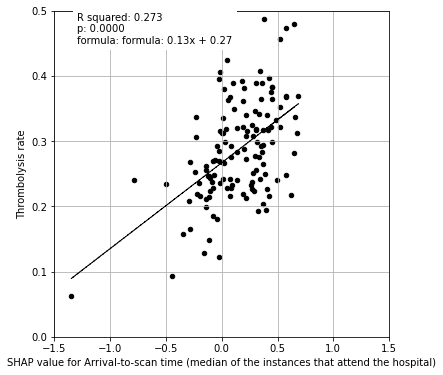

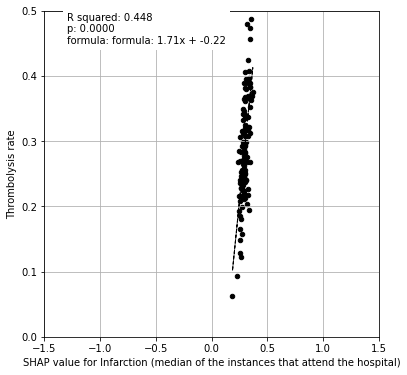

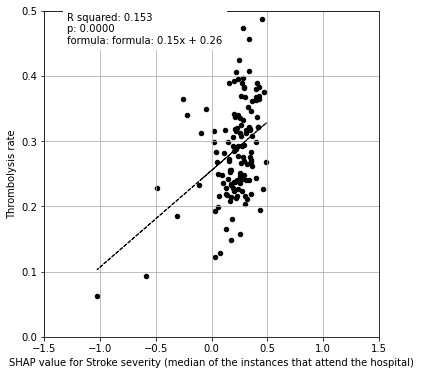

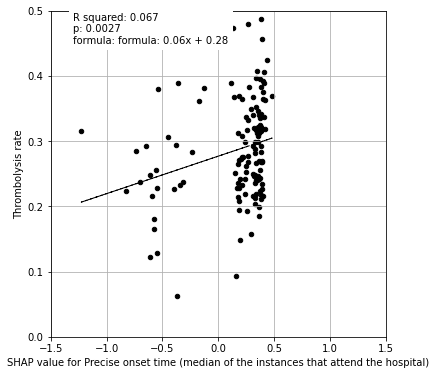

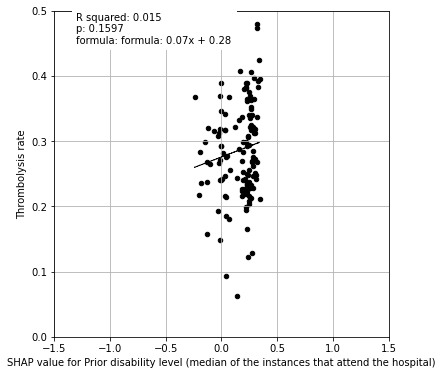

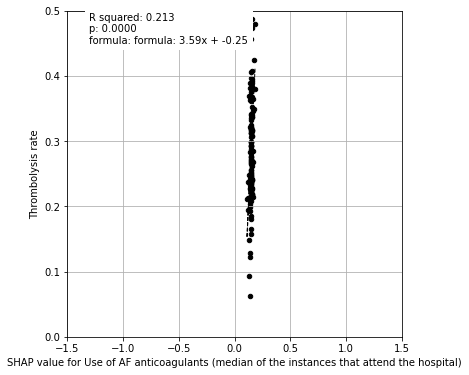

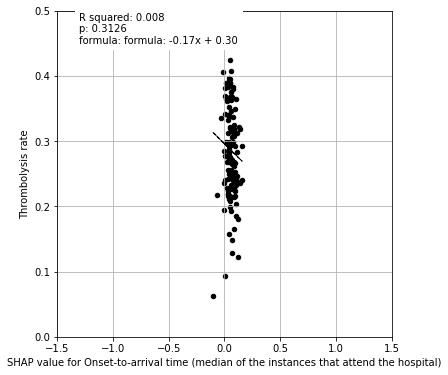

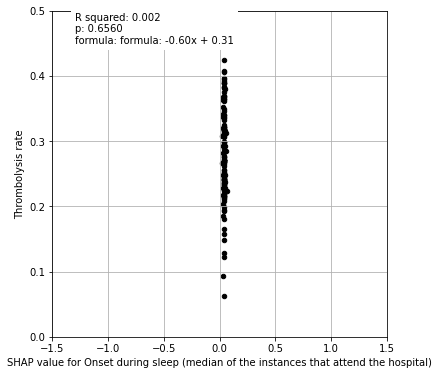

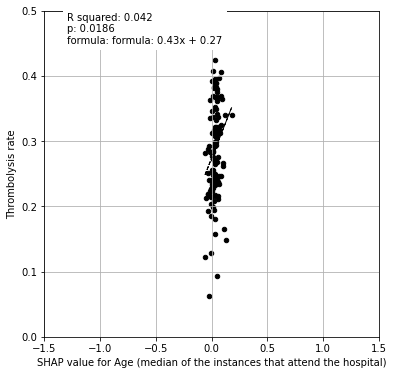

In [94]:
features_to_plot = ['Arrival-to-scan time','Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

for feat in features_to_plot: 
    # Setup data for chart
    x = df_median_shap_values_per_hosp[feat]
    y = df_median_shap_values_per_hosp['Thrombolysis']

    # Fit a regression line to the x2 points
    slope, intercept, r_value, p_value, std_err = \
        stats.linregress(x, y)
    r_square = r_value ** 2
    y_pred = intercept + (x * slope)

    # Create scatter plot with regression line
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1)

    ax.scatter(x, y, color = 'k', marker="o", s=20)
    ax.plot (x, y_pred, color = 'k', linestyle='--', linewidth=1)

    ax.set_xlabel(f"SHAP value for {feat} "
                  f"(median of the instances that attend the hospital)")
    ax.set_ylabel('Thrombolysis rate')

    ax.set_ylim(0, 0.5)
    ax.set_xlim(-1.5, 1.5)


    plt.grid()

    # Add  text
    f = ('formula: ' + str("{:.2f}".format(slope)) + 'x + ' + 
          str("{:.2f}".format(intercept)))
    text = (f'R squared: {r_square:.3f}\np: '
             f'{p_value:0.4f}\nformula: {f}')
    
    ax.text(-1.3, 0.45, text, 
             bbox=dict(facecolor='white', edgecolor='white'))

    # Save figure

#    plt.savefig(f'./output/{notebook}_{model_text}'
#                f'_attended_hosp_shap_value.jpg', 
#                dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.show()

In [100]:
X = df_median_shap_values_per_hosp[features_to_plot]
y = df_median_shap_values_per_hosp['Thrombolysis']

regr = linear_model.LinearRegression()
regr.fit(X, y)

df_reg_coeff = pd.DataFrame(data = regr.coef_, index = features_to_plot, columns=["coeff"])
df_reg_coeff

,coeff
Arrival-to-scan time,0.041967
Infarction,1.139265
Stroke severity,0.010025
Precise onset time,0.001260
Prior disability level,0.012179
Use of AF anticoagulants,2.489398
Onset-to-arrival time,-0.160718
Onset during sleep,0.840179
Age,0.303567


In [102]:
y_pred = regr.predict(X)

# Fit a regression line to the obs and pred IVT use
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(y, y_pred)
r_square = r_value ** 2
y_pred = intercept + (y * slope)
print(r_square)

0.5824029830073513


Add in the median SHAP value for the hospital feature (already calculated in notebook 03c)

In [111]:
filename = (f'./output/03c_{model_text}'
            f'_attended_hosp_shap_value.csv')
df_hosp_shap = pd.read_csv(filename)#[['shap_median_sv','Thrombolysis']]
df_hosp_shap = df_hosp_shap.set_index("hospital")

In [117]:
df_median_shap_values_per_hosp = df_median_shap_values_per_hosp.join(df_hosp_shap, rsuffix="h_")
df_median_shap_values_per_hosp

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,team_AGNOF1041H,...,team_XWUBX0795L,team_YEXCH8391J,team_YPKYH1768F,team_YQMZV4284N,team_ZBVSO0975W,team_ZHCLE1578P,team_ZRRCV7012C,Thrombolysis,shap_median_sv,Thrombolysish_
CNBGF2713O,0.648007,0.313526,-0.084391,0.266955,0.316369,0.183601,-0.016096,0.033696,0.023135,0.001011,...,-0.004961,0.000571,0.000010,-0.001658,0.002115,-0.001371,0.002244,0.480263,1.365023,0.480263
UALFR2142B,-0.287873,0.240931,0.050026,0.262097,0.271370,0.146735,0.024119,0.035143,0.045624,0.000719,...,-0.002366,0.000255,0.000262,-0.001622,0.002358,-0.001633,0.002825,0.267697,0.178760,0.267697
OKVRY7006H,0.267958,0.297781,0.196918,-0.311535,0.246114,0.148661,0.132020,0.039454,0.058468,0.000838,...,-0.003113,0.000384,0.000683,-0.001891,0.002446,-0.001678,0.002824,0.237500,-0.295860,0.237500
FLVXS2956M,0.414227,0.311638,0.347694,0.338794,0.029986,0.153958,0.062017,0.035031,0.032740,0.001038,...,-0.003654,0.000384,0.000262,-0.001764,0.002346,-0.001482,0.003422,0.316294,-0.054791,0.316294
DZJVD1372Z,0.339327,0.291655,0.259213,0.238247,0.211112,0.134613,0.036551,0.036981,0.022837,0.000845,...,-0.003926,0.000479,0.000262,-0.001835,0.002304,-0.001553,0.003118,0.241144,-0.201307,0.241144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HZMLX7970T,0.400151,0.339376,0.431362,0.182151,0.216984,0.122189,-0.003791,0.039094,0.024677,0.000893,...,-0.003666,0.000406,0.000262,-0.001974,0.002523,-0.001633,0.002825,0.194286,-1.232265,0.194286
OYASQ1316D,-0.011340,0.276689,0.219570,0.380844,-0.068810,0.157261,0.056102,0.036718,0.036680,0.000732,...,-0.002538,0.000291,0.000262,-0.001779,0.003180,-0.001912,0.003999,0.316056,0.414163,0.316056
QWKRA8499D,0.020499,0.306505,0.395418,-0.544427,0.201917,0.181896,0.072786,0.045268,0.047553,0.000673,...,-0.002340,0.000291,0.000683,-0.001144,0.002522,-0.001681,0.003737,0.379195,0.837098,0.379195
UIWEN7236N,-0.042457,0.297910,0.235684,0.386146,0.225305,0.150747,0.096319,0.037392,-0.018870,0.000753,...,-0.002300,0.000291,0.000262,-0.001827,0.002709,-0.001682,0.003242,0.292264,-0.155942,0.292264


In [120]:
features_to_plot.append("shap_median_sv")
X = df_median_shap_values_per_hosp[features_to_plot]
y = df_median_shap_values_per_hosp['Thrombolysis']

regr = linear_model.LinearRegression()
regr.fit(X, y)

df_reg_coeff = pd.DataFrame(data = regr.coef_, index = features_to_plot, columns=["coeff"])
df_reg_coeff

,coeff
Arrival-to-scan time,0.008584
Infarction,1.322192
Stroke severity,-0.018757
Precise onset time,0.021022
Prior disability level,0.039181
Use of AF anticoagulants,0.201946
Onset-to-arrival time,-0.079763
Onset during sleep,-0.760929
Age,0.122432
shap_median_sv,0.104058


In [121]:
y_pred = regr.predict(X)

# Fit a regression line to the obs and pred IVT use
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(y, y_pred)
r_square = r_value ** 2
y_pred = intercept + (y * slope)
print(r_square)

0.9470494027483449
